In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
import json
from sklearn.model_selection import KFold

sns.set_style('ticks', {'axes.grid': False})
sns.set_context("paper", font_scale=1.2, rc={'lines.markersize': 8})

In [2]:
folds = 6
indexes = list(range(48))
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
kf.get_n_splits(indexes)

FOLD_DICT = {k+1: list(v[1]+1) for k, v in enumerate(list(kf.split(indexes)))}

In [3]:
FOLD_DICT

{1: [13, 20, 25, 27, 28, 38, 41, 44],
 2: [4, 5, 7, 9, 14, 26, 34, 40],
 3: [10, 16, 17, 18, 30, 33, 46, 47],
 4: [1, 2, 6, 12, 31, 32, 35, 45],
 5: [3, 11, 22, 23, 24, 36, 37, 42],
 6: [8, 15, 19, 21, 29, 39, 43, 48]}

In [4]:
def get_quality_counts(qualities):
    return [qualities.count(1), qualities.count(2)]

In [5]:
K = -1
LOGS_PATH_TMP = '../logs/logs_pred_model/k{K}_{variant}mbps_lpoa_mult'.format(K=K, variant='{variant}')
VIDEO_LIST = [0,2,4]
VIDEO_TITLES = ['Sandwich', 'Spotlight', 'Surf']
# USER_LIST = range
# QUALITIES = [1, 2, 3, 4, 5]
TIME_FILE_TMPL = 'log_seg_u{user}_prefetch.txt'
NP_TIME_FILE_TMPL = 'log_seg_u{user}_no_prefetch.txt'
QUALITY_FILE_TMPL = 'log_seg_quality_u{user}_prefetch.txt'
NP_QUALITY_FILE_TMPL = 'log_seg_quality_u{user}_no_prefetch.txt'
FREEZES_FILE_TMPL = 'log_seg_freezes_u{user}_prefetch.txt'
NP_FREEZES_TIME_FILE_TMPL = 'log_seg_freezes_u{user}_no_prefetch.txt'
# VARIANTS = {'dyn_vp_cc': 'NCP', 'dyn_vp_hw': 'HWP', 'dyn_vp_sc': 'NSP'}
VARIANTS = range(10,55,5)
# THRESHOLDS = [90]
SEG_DUR = 1.065

results_list = []
prefetch_flag = False

for var in VARIANTS:
#     for th in THRESHOLDS:
    for v in VIDEO_LIST:
        for fold in FOLD_DICT:
            for u in FOLD_DICT[fold]:
                for (times_tmpl, qualities_tmpl, freezes_tmpl) in [(TIME_FILE_TMPL, QUALITY_FILE_TMPL, FREEZES_FILE_TMPL), (NP_TIME_FILE_TMPL, NP_QUALITY_FILE_TMPL, NP_FREEZES_TIME_FILE_TMPL)]:
                    prefetch_flag = not prefetch_flag
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{qualities_tmpl.format(user=u)}', 'r') as q_file:
                        p_qualities = [get_quality_counts([int(x) for x in json.loads(line)]) for line in q_file]
                        p_df = pd.DataFrame(p_qualities, columns=['lq', 'hq'])
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{freezes_tmpl.format(user=u)}', 'r') as f_file:
                        p_n_freezes, p_freezes_dur = (float(i) for i in f_file.readline().split(', '))
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{times_tmpl.format(user=u)}', 'r') as t_file:
                        p_times, p_bandwidth = zip(*[(float(t.split(', ')[0].strip()), float(t.split(', ')[1].strip())) for t in t_file.readlines()])
#                             p_df = pd.DataFrame(columns=['video', 'user', 'prefetch', 'bitrate', 'threshold', 'seg_resp_time'])
                        p_df['seg_resp_time'] = p_times
                        p_df['perceived_bandwidth'] = np.array(p_bandwidth)/1000000.
                        p_df['segment'] = p_df.index + 1
                        p_df['video'] = VIDEO_TITLES[int(v/2)]
                        p_df['user'] = u
                        p_df['prefetch'] = 'PREFETCH' if prefetch_flag else f'NO_PREFETCH'
                        p_df['bitrate'] = var
#                         p_df['threshold'] = th
                        p_df['n_freezes'] = p_n_freezes
                        p_df['freezes_dur'] = p_freezes_dur
                        p_df['hq_ratio'] = p_df.apply(lambda r: r.hq/(r.hq + r.lq), axis=1)
                        p_df['lq_ratio'] = 1 - p_df['hq_ratio']
                        results_list.append(p_df)
                
results_df = pd.concat(results_list, ignore_index=True)

In [6]:
results_df

,lq,hq,seg_resp_time,perceived_bandwidth,segment,video,user,prefetch,bitrate,n_freezes,freezes_dur,hq_ratio,lq_ratio
0,16,0,0.183813,0.741971,1,Sandwich,13,PREFETCH,10,0.0,0.0,0.0000,1.0000
1,16,0,0.249167,1.162625,2,Sandwich,13,PREFETCH,10,0.0,0.0,0.0000,1.0000
2,16,0,0.322141,3.477310,3,Sandwich,13,PREFETCH,10,0.0,0.0,0.0000,1.0000
3,16,0,0.406757,4.061960,4,Sandwich,13,PREFETCH,10,0.0,0.0,0.0000,1.0000
4,13,3,0.641409,5.584309,5,Sandwich,13,PREFETCH,10,0.0,0.0,0.1875,0.8125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77755,0,16,1.020567,18.077156,26,Surf,48,NO_PREFETCH,50,0.0,0.0,1.0000,0.0000
77756,0,16,0.901335,19.422798,27,Surf,48,NO_PREFETCH,50,0.0,0.0,1.0000,0.0000
77757,0,16,0.957441,20.552478,28,Surf,48,NO_PREFETCH,50,0.0,0.0,1.0000,0.0000
77758,0,16,0.989637,21.914227,29,Surf,48,NO_PREFETCH,50,0.0,0.0,1.0000,0.0000


In [7]:
results_df['freeze_to_playback'] = round(results_df['freezes_dur'] / (30 * SEG_DUR), 2)

In [8]:
# k_unique = results_df['k'].unique().tolist()
v_unique = results_df['video'].unique().tolist()

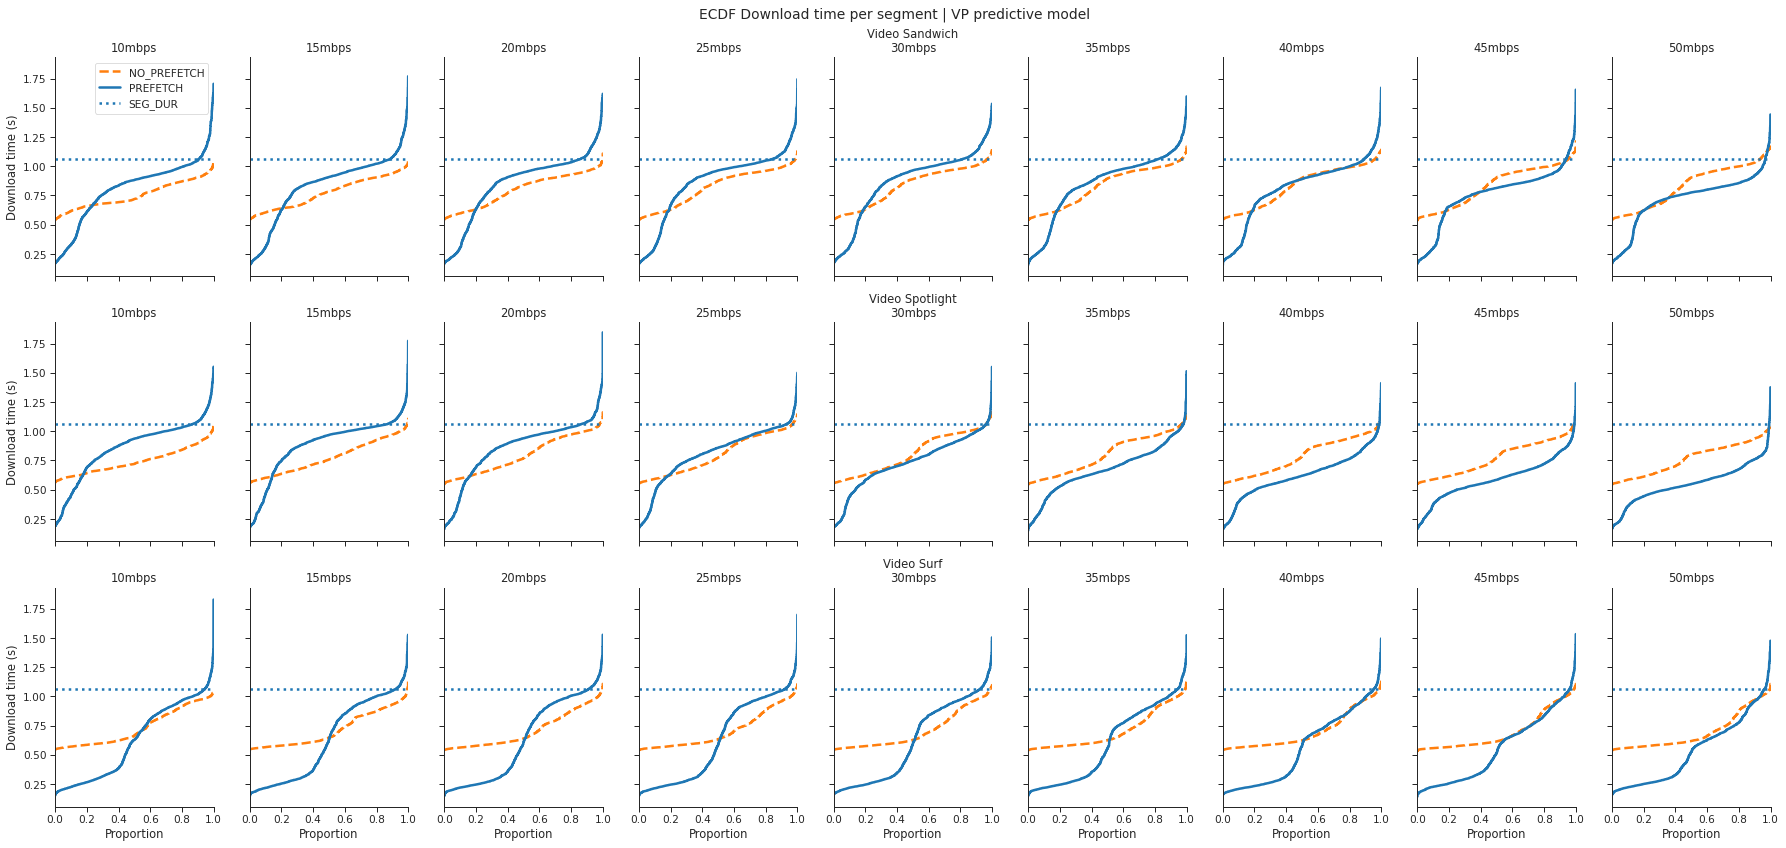

In [9]:
fig, axes = plt.subplots(len(v_unique), len(VARIANTS), figsize=(25,12), sharex=True, sharey=True)
th = 90

for i in range(len(v_unique)):
    for j in range(len(VARIANTS)):
        axis = axes[i][j]
#         axis = axes[j]
        sns.ecdfplot(
            data=results_df[(results_df['video'] == v_unique[i]) & (results_df['bitrate'] == VARIANTS[j])], 
            y="seg_resp_time", 
            linewidth=2.5, 
            hue="prefetch",
            legend=True,
            ax=axis
        )
        sns.despine()

        axis.lines[0].set_linestyle("--")
        leg = axis.get_legend()
        leg_texts = [t.get_text() for t in leg.texts]
        leg.get_lines()[leg_texts.index(f'NO_PREFETCH')].set_linestyle("--")
        axis.set_title(f'Video {VIDEO_TITLES[i]}\n{VARIANTS[j]}mbps' if j==int(len(VARIANTS)/2) else f'{VARIANTS[j]}mbps')
        axis.axhline(y=SEG_DUR, label='SEG_DUR', linewidth=2.5, linestyle=":")
#         axis.set_title(f'Video {j*2}')
        axis.set_ylabel('Download time (s)')
        axis.get_legend().set_title("")
        axis.legend(
            handles=[axis.lines[0], axis.lines[1], axis.lines[2]],#, axis.lines[0], axis.lines[4]], 
            labels=["NO_PREFETCH", f"PREFETCH", "SEG_DUR"]#, f"HWP_{THRESHOLDS[i]}", f"NSP_{THRESHOLDS[i]}", "SEG_DUR"]
        )
        if j != 0 or i != 0:
            axis.get_legend().remove()
            
    #     axis.set_xlim(0,2.5)
plt.suptitle(f'ECDF Download time per segment | VP predictive model')
plt.tight_layout()

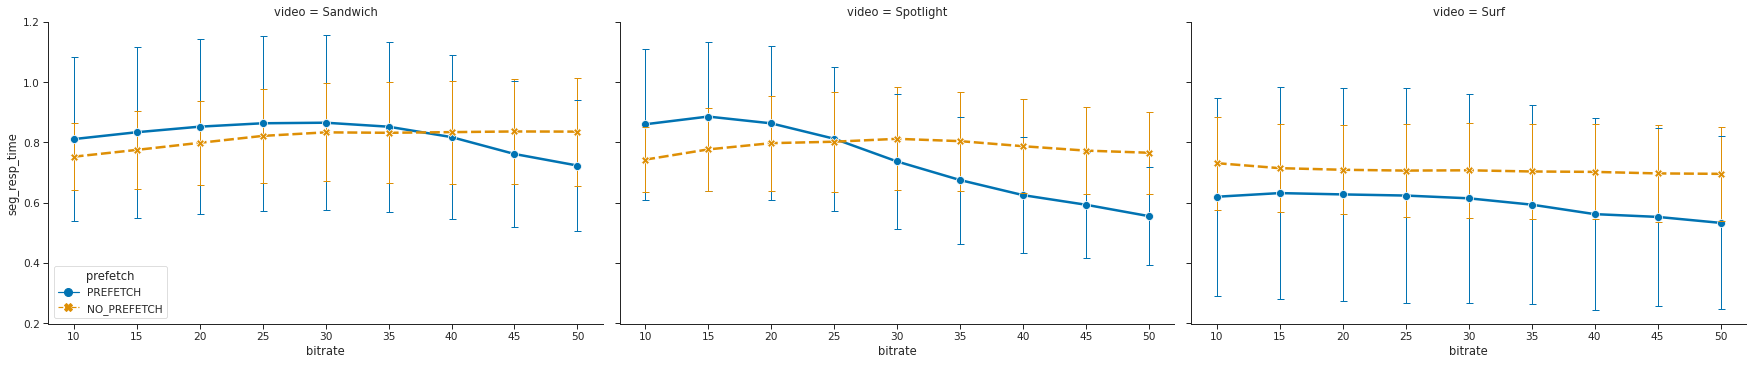

In [10]:
sns.relplot(x="bitrate", y="seg_resp_time", 
            kind="line", palette='colorblind', col='video',
            err_style='bars', err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
            ci='sd', markers=True, style='prefetch', hue='prefetch', linewidth=2.5, 
            data=results_df, height=5, aspect=1.618, facet_kws = {'legend_out': False})

# sns.lineplot(x="bitrate", y="seg_resp_time", hue="prefetch", data=results_df, err_style='bars', elinewidth=1.0, capsize= 3.5)

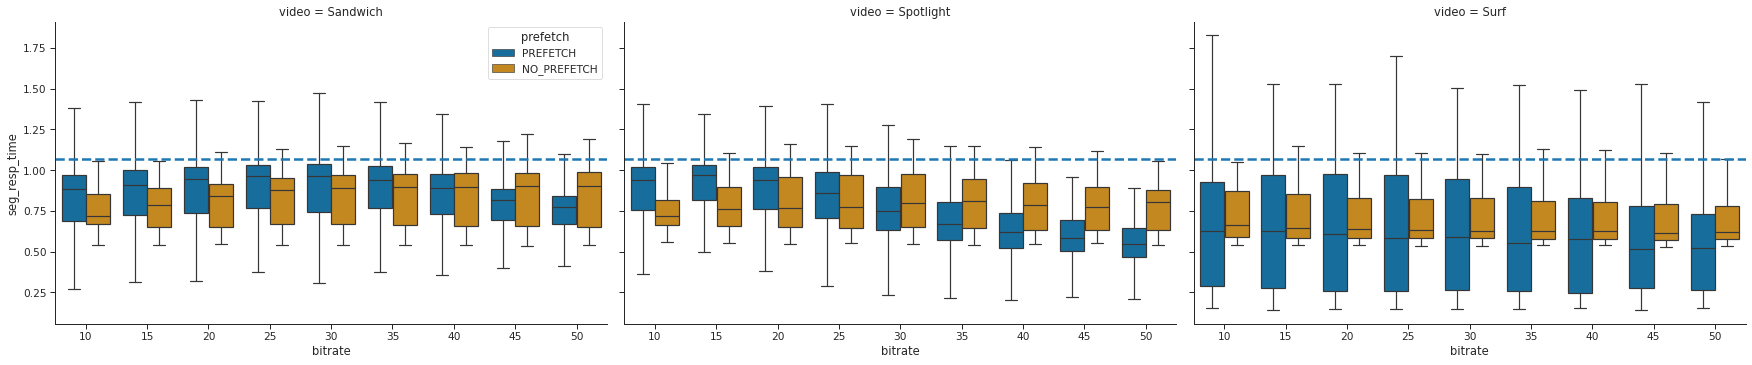

In [11]:
g = sns.catplot(x="bitrate", y="seg_resp_time", 
            kind="box", palette='colorblind',
            hue='prefetch', data=results_df, 
            height=5, aspect=1.618, showfliers=False,
            legend_out=False, col='video')

for ax in g.axes.flat:
    ax.axhline(y=SEG_DUR, label='SEG_DUR', linewidth=2.5, linestyle="--")

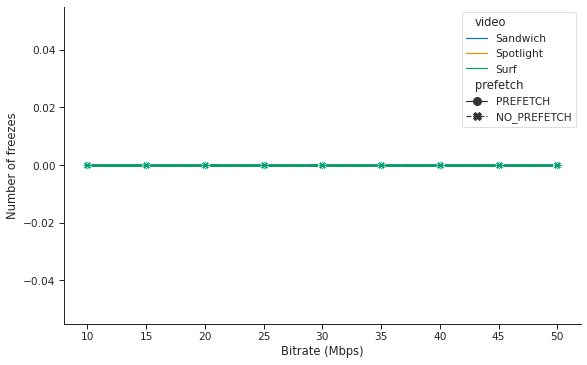

In [12]:
g = sns.relplot(x="bitrate", y="n_freezes", 
            kind="line", palette='colorblind', hue='video',
            err_style='bars', err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
            ci=68, markers=True, style='prefetch', linewidth=2.5, # ci=68: Standard error of the mean
            data=results_df, height=5, aspect=1.618, facet_kws = {'legend_out': False})
g.set(ylabel='Number of freezes', xlabel='Bitrate (Mbps)')

<ipython-input-13-284b29c2645c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


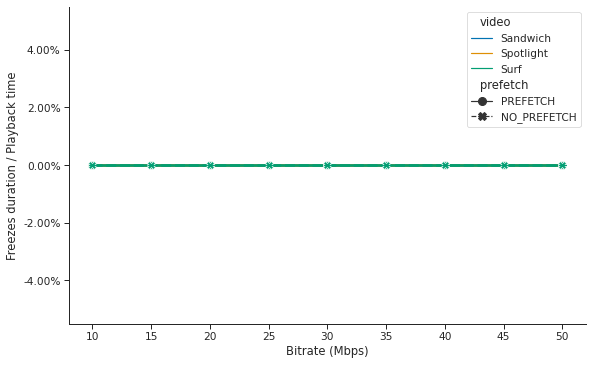

In [13]:
g = sns.relplot(x="bitrate", y="freeze_to_playback", 
            kind="line", palette='colorblind', hue='video',#col='video',
            err_style='bars', err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
            ci=68, markers=True, style='prefetch', linewidth=2.5, # ci=68: Standard error of the mean
            data=results_df, height=5, aspect=1.618, facet_kws = {'legend_out': False})
g.set(ylabel='Freezes duration / Playback time', xlabel='Bitrate (Mbps)')

for ax in g.axes.flat:
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

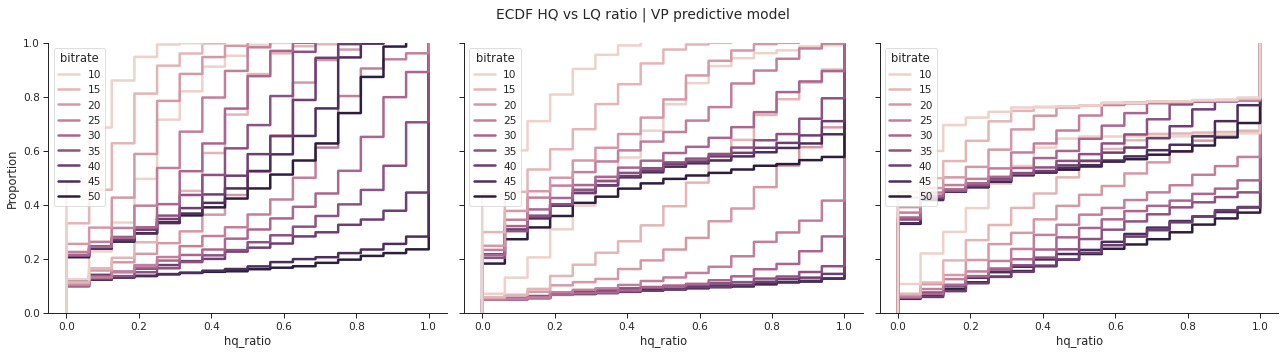

In [14]:
fig, axes = plt.subplots(1, len(v_unique), figsize=(18,5), sharex=True, sharey=True)

for i in range(len(v_unique)):
#     for j in range(len(VARIANTS)):
#         axis = axes[i][j]
    axis = axes[i]
    sns.ecdfplot(
        data=results_df[(results_df['video'] == v_unique[i]) & (results_df['prefetch'] == 'PREFETCH')], 
        x="hq_ratio", 
        linewidth=2.5, 
        hue="bitrate",
        legend=True,
        ax=axis
    )
    sns.ecdfplot(
        data=results_df[(results_df['video'] == v_unique[i]) & (results_df['prefetch'] == 'NO_PREFETCH')], 
        x="hq_ratio", 
        linewidth=2.5, 
        hue="bitrate",
        legend=True,
        ax=axis
    )
    sns.despine()

#         axis.lines[0].set_linestyle("--")
#         leg = axis.get_legend()
#         leg_texts = [t.get_text() for t in leg.texts]
#         leg.get_lines()[leg_texts.index(f'NO_PREFETCH')].set_linestyle("--")
#         axis.set_title(f'Video {VIDEO_TITLES[i]}\n{VARIANTS[j]}mbps' if j==int(len(VARIANTS)/2) else f'{VARIANTS[j]}mbps')
#         axis.axhline(y=SEG_DUR, label='SEG_DUR', linewidth=2.5, linestyle=":")
# #         axis.set_title(f'Video {j*2}')
#         axis.set_ylabel('Download time (s)')
#         axis.get_legend().set_title("")
#         axis.legend(
#             handles=[axis.lines[0], axis.lines[1], axis.lines[2]],#, axis.lines[0], axis.lines[4]], 
#             labels=["NO_PREFETCH", f"PREFETCH", "SEG_DUR"]#, f"HWP_{THRESHOLDS[i]}", f"NSP_{THRESHOLDS[i]}", "SEG_DUR"]
#         )
    #     axis.set_xlim(0,2.5)
plt.suptitle(f'ECDF HQ vs LQ ratio | VP predictive model')
plt.tight_layout()

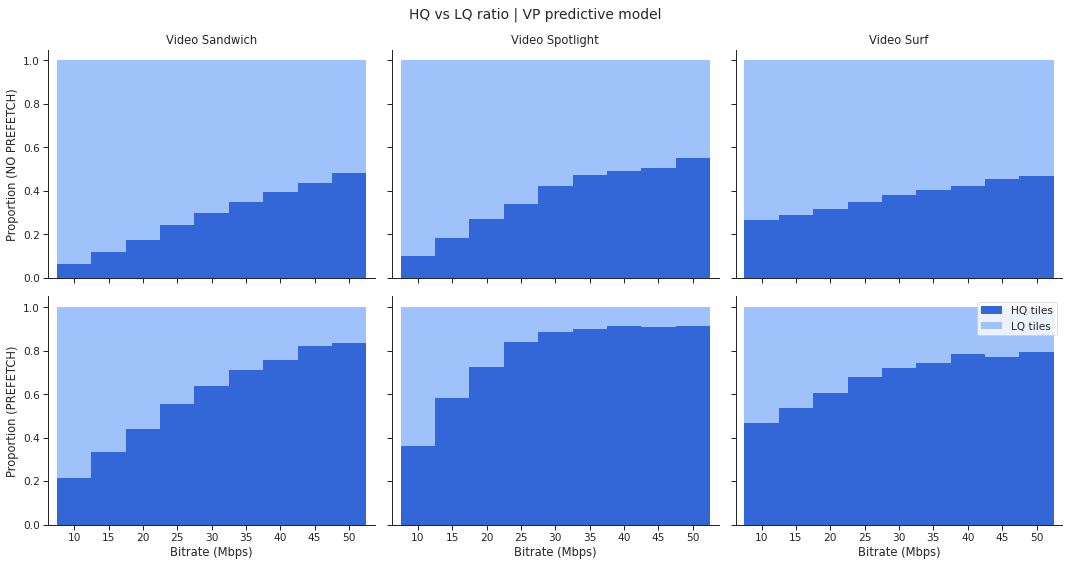

In [15]:
fig, axes = plt.subplots(2, len(v_unique), figsize=(15,8), sharex=True, sharey=True)
prefetch_labels = ['NO_PREFETCH', 'PREFETCH']
hq_lq_ratio_df = results_df[['video', 'bitrate', 'prefetch', 'hq_ratio', 'lq_ratio']].groupby(['video', 'prefetch', 'bitrate']).mean().reset_index()

for i in range(2):
    for j in range(len(v_unique)):
        axis = axes[i][j]
#         axis = axes[i]
        hq_lq_ratio_df[(hq_lq_ratio_df['video'] == v_unique[j]) & (hq_lq_ratio_df['prefetch'] == prefetch_labels[i])].plot.bar(
            x='bitrate', 
            stacked=True, 
            ax=axis, 
            width=1, 
#             cmap='tab20b',
            rot=0,
            color=['#3366d6', '#a0c2fa'],
            linewidth=0
        )
#         sns.despine()
        axis.spines.right.set_visible(False)
        axis.spines.top.set_visible(False)
        axis.get_legend().remove()
        axis.set_xlabel('Bitrate (Mbps)')
        axis.set_ylabel(f'Proportion ({"PREFETCH" if prefetch_labels[i] == "PREFETCH" else "NO PREFETCH"})')
        if i == 0:
            axis.set_title(f'Video {VIDEO_TITLES[j]}')

plt.suptitle(f'HQ vs LQ ratio | VP predictive model')
plt.tight_layout()
plt.legend(labels=['HQ tiles', 'LQ tiles'])


In [16]:
(hq_lq_ratio_df.pivot(index=['bitrate'], columns=['prefetch', 'video'], values='hq_ratio').pct_change(axis=1)['PREFETCH']*100)#.plot(kind='bar')

video,Sandwich,Spotlight,Surf
bitrate,,,
10,230.836120,261.086957,75.714519
15,179.146919,217.589962,84.091927
20,150.148002,168.741935,90.249898
25,126.645435,147.735728,93.065015
30,111.906829,110.091743,89.664230
35,103.999502,89.436684,83.534824
40,91.088891,85.040479,84.727198
45,88.906608,80.526406,70.469349
50,72.810481,66.044423,70.013001


Text(0.5, 0.98, 'Distribution of the number of tiles per segment retrieved in HQ')

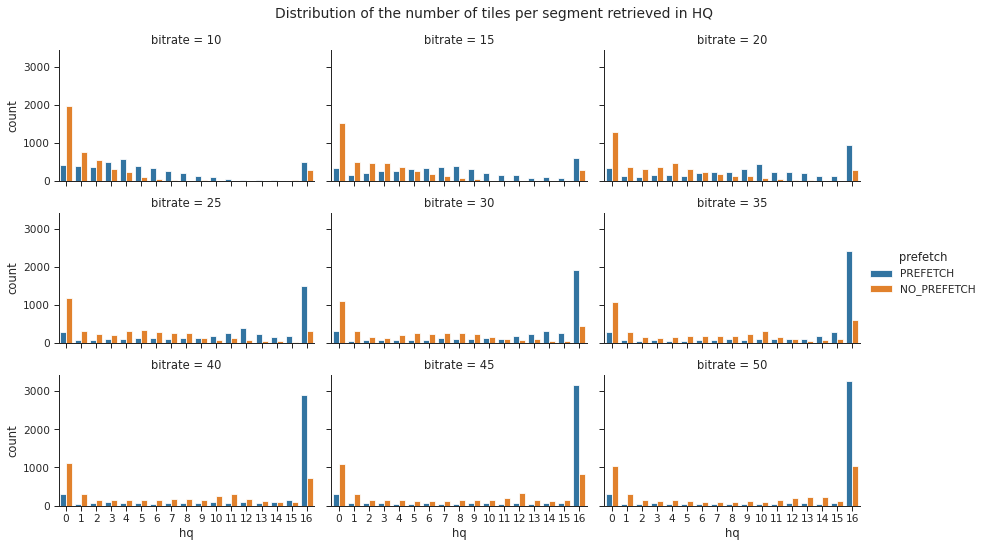

In [17]:
ax = sns.catplot(x="hq", hue="prefetch", data=results_df, kind="count", height=2.5, aspect=1.602, col='bitrate', col_wrap=3)# ax.axes[0][0].set_xlabel('# HQ tiles')
# ax.axes[0][0].set_title('Distribution of the number of tiles per segment retrieved in HQ\n (Setup: DASH, CTF, spherical walk pred.)')
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle('Distribution of the number of tiles per segment retrieved in HQ')

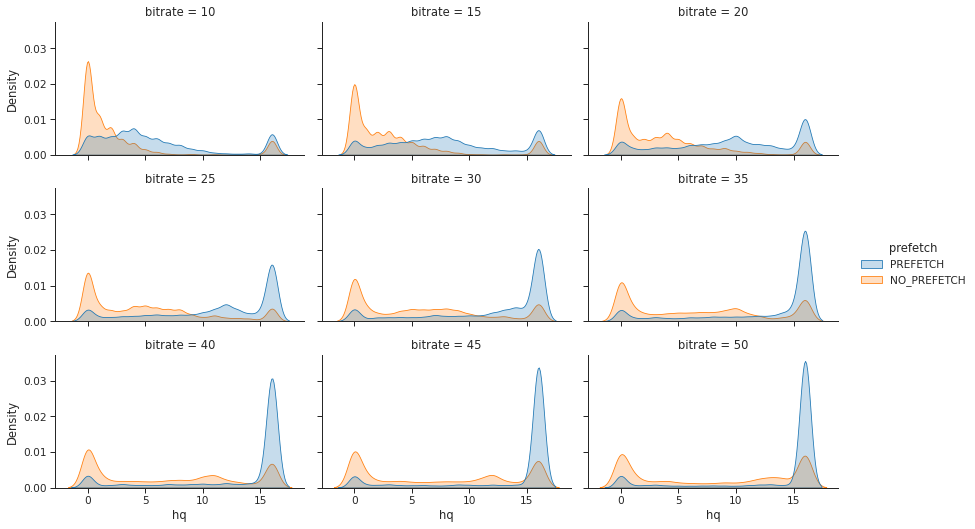

In [18]:
ax = sns.displot(x="hq", hue="prefetch", data=results_df, height=2.5, aspect=1.602, col='bitrate', col_wrap=3, kind="kde", fill=True, bw_adjust=.5)

Text(0.5, 1.0, 'Proportion of HQ tiles per segment\n (Setup: DASH, CTF, spherical walk pred.)')

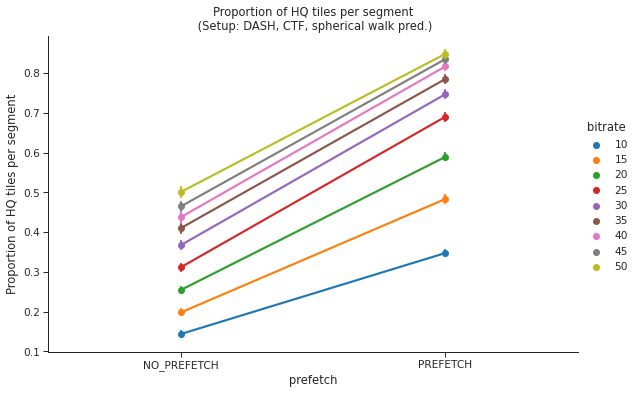

In [19]:
ax = sns.catplot(x="prefetch", y="hq_ratio", hue="bitrate", data=results_df, kind="point", height=5, aspect=1.602, order=['NO_PREFETCH', 'PREFETCH'])
ax.axes[0][0].set_ylabel('Proportion of HQ tiles per segment')
ax.axes[0][0].set_title('Proportion of HQ tiles per segment\n (Setup: DASH, CTF, spherical walk pred.)')

Text(0.5, 1.0, 'Proportion of HQ tiles per segment\n (Setup: DASH, CTF, spherical walk pred.)')

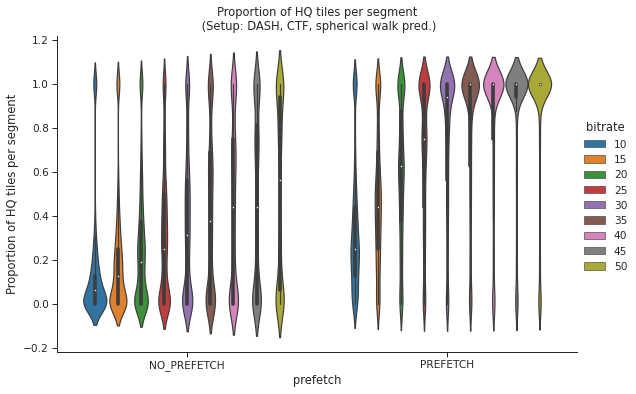

In [20]:
ax = sns.catplot(x="prefetch", y="hq_ratio", hue="bitrate", data=results_df, kind="violin", height=5, aspect=1.602, order=['NO_PREFETCH', 'PREFETCH'])
ax.axes[0][0].set_ylabel('Proportion of HQ tiles per segment')
ax.axes[0][0].set_title('Proportion of HQ tiles per segment\n (Setup: DASH, CTF, spherical walk pred.)')

In [21]:
QUALITY_FILE_TMPL = 'log_seg_quality_u{user}_prefetch.txt'
NP_QUALITY_FILE_TMPL = 'log_seg_quality_u{user}_no_prefetch.txt'

qualities_list = []
prefetch_flag = False
t_hor = 4
t_vert = 4

for var in VARIANTS:
    for v in VIDEO_LIST:
        for fold in FOLD_DICT:
            for u in FOLD_DICT[fold]:
                for times_tmpl in [QUALITY_FILE_TMPL, NP_QUALITY_FILE_TMPL]:
                    prefetch_flag = not prefetch_flag
                    with open(f'{LOGS_PATH_TMP.format(variant=var)}/fold{fold}/{v}/{times_tmpl.format(user=u)}', 'r') as p_file:
                        p_qualities = [[int(x) for x in json.loads(line)] for line in p_file]
                        p_df = pd.DataFrame(p_qualities, columns=[f'tile_{i}' for i in range(t_hor*t_vert)])
                        p_df['segment'] = p_df.index + 1
                        p_df['video'] = v
                        p_df['user'] = u
                        p_df['bitrate'] = var
                        p_df['prefetch'] = 'PREFETCH' if prefetch_flag else f'NO_PREFETCH'
                        qualities_list.append(p_df)
                
qualities_df = pd.concat(qualities_list, ignore_index=True)

In [22]:
qualities_df

,tile_0,tile_1,tile_2,tile_3,tile_4,tile_5,tile_6,tile_7,tile_8,tile_9,...,tile_11,tile_12,tile_13,tile_14,tile_15,segment,video,user,bitrate,prefetch
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,13,10,PREFETCH
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,2,0,13,10,PREFETCH
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,3,0,13,10,PREFETCH
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,4,0,13,10,PREFETCH
4,1,2,2,1,1,2,1,1,1,1,...,1,1,1,1,1,5,0,13,10,PREFETCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77755,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,26,4,48,50,NO_PREFETCH
77756,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,27,4,48,50,NO_PREFETCH
77757,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,28,4,48,50,NO_PREFETCH
77758,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,29,4,48,50,NO_PREFETCH


In [23]:
def plot_quality_heatmap(u_id, v_id, truncate=len(VARIANTS)):
    fig, axes = plt.subplots(len(VARIANTS[:truncate]), 2, figsize=(18, int(40*(truncate/9))), sharey=True)

    for i in range(0,len(VARIANTS[:truncate])):
        for j in range(2):
            ax = axes[i][j]
            sns.heatmap(
                data = qualities_df[
                    (qualities_df['user'] == u_id) & 
                    (qualities_df['video'] == v_id) &
                    (qualities_df['prefetch'] == ('NO_PREFETCH' if j == 0 else 'PREFETCH')) &
                    (qualities_df['bitrate'] == VARIANTS[i])
                    ][['segment']+[f'tile_{t}' for t in range(t_hor*t_vert)]].set_index('segment').T, 
                linewidths=.1, 
                cmap="Blues",
                vmin=1.,
                vmax=2.,
                ax=ax)
            if i == 0:
                ax.set_title(f'Requested quality per tile ({"NO_PREFETCH" if j == 0 else "PREFETCH"})')
            ax.set_xlabel('Segment')
            ax.set_ylabel(f'{VARIANTS[i]}Mbps')

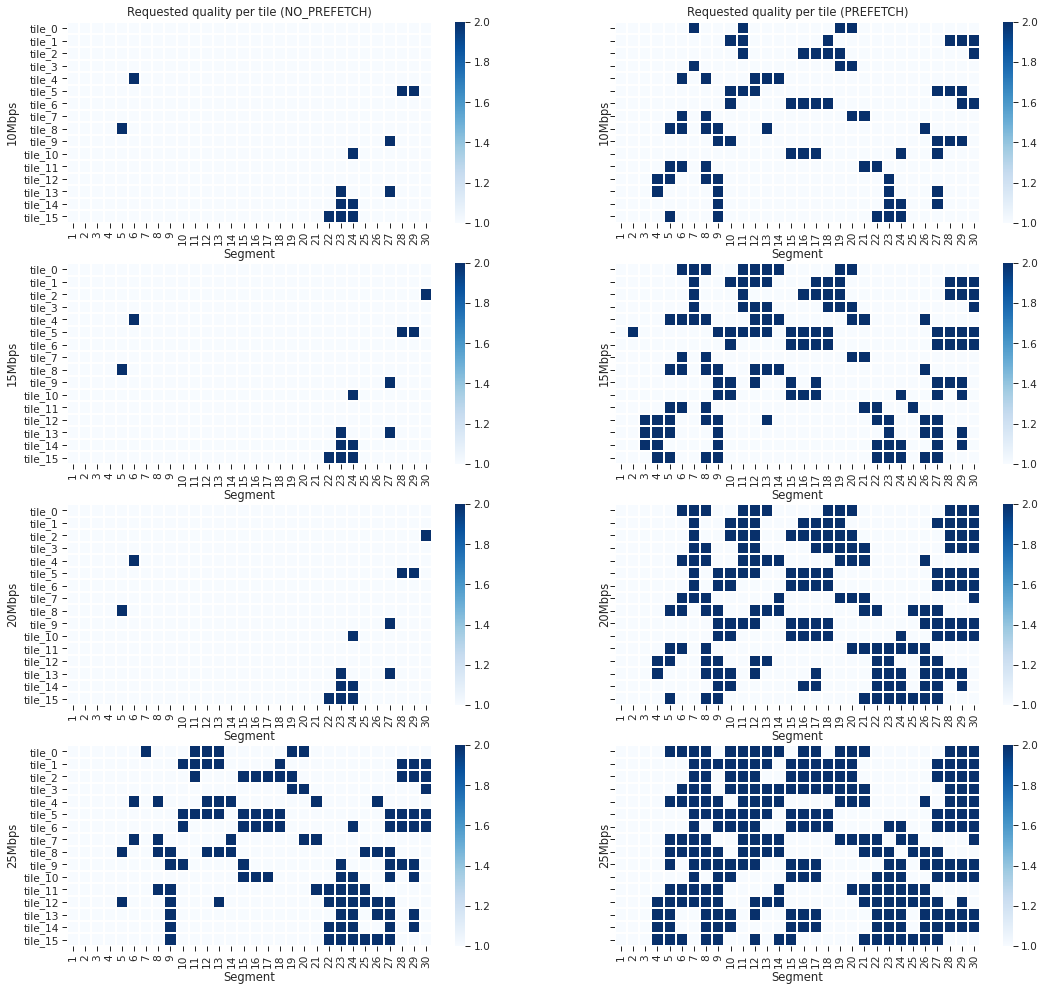

In [24]:
u_id = 25
v_id = 0

plot_quality_heatmap(u_id, v_id, truncate=4)

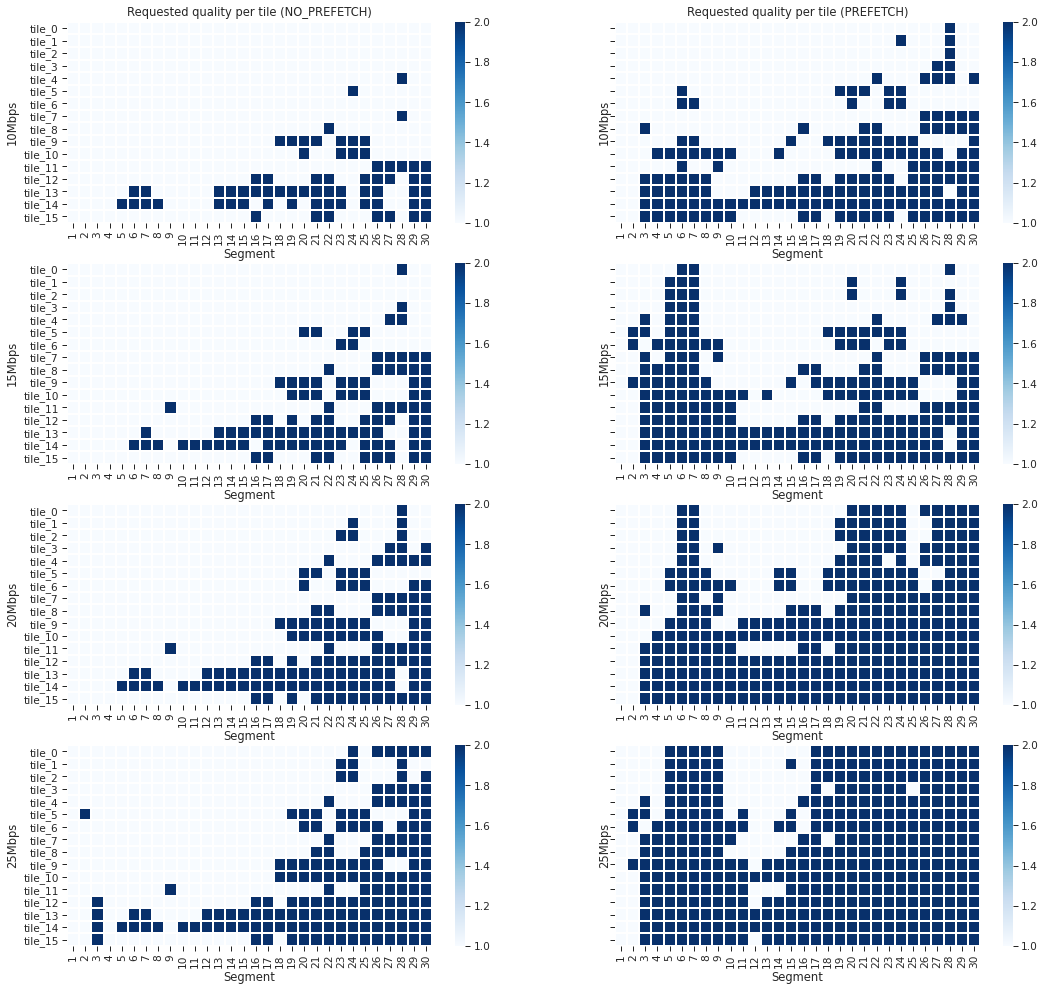

In [25]:
v_id = 2

plot_quality_heatmap(u_id, v_id, truncate=4)

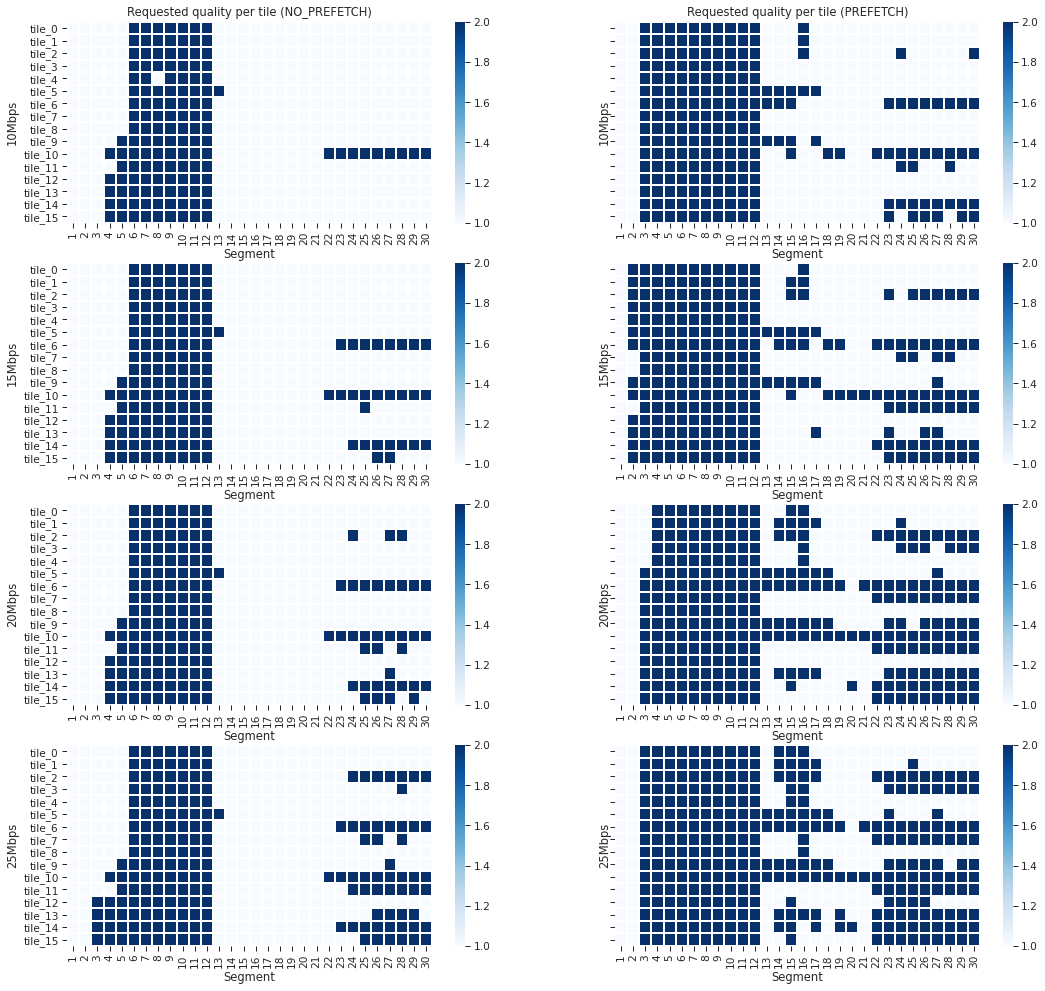

In [26]:
v_id = 4

plot_quality_heatmap(u_id, v_id, truncate=4)

<AxesSubplot:xlabel='hq', ylabel='Proportion'>

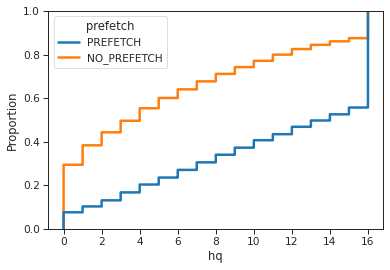

In [27]:
sns.ecdfplot(data=results_df, 
            x="hq", 
            linewidth=2.5, 
            hue="prefetch",
            legend=True
)

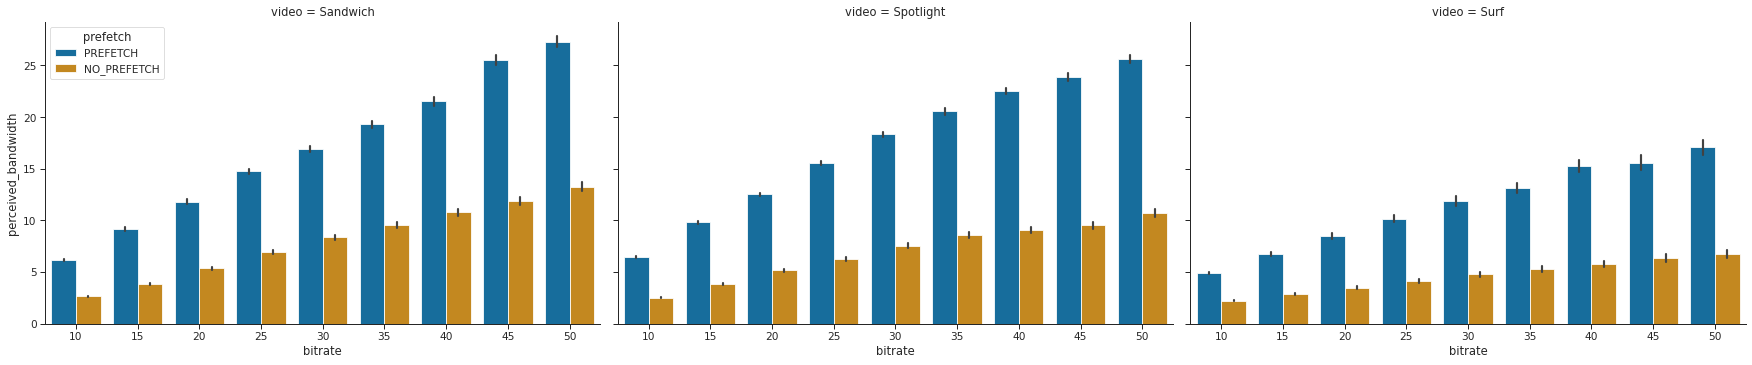

In [28]:
g = sns.catplot(x="bitrate", y="perceived_bandwidth", 
            kind="bar", palette='colorblind',
            hue='prefetch', data=results_df, 
            height=5, aspect=1.618,# showfliers=False,
            legend_out=False, col='video')

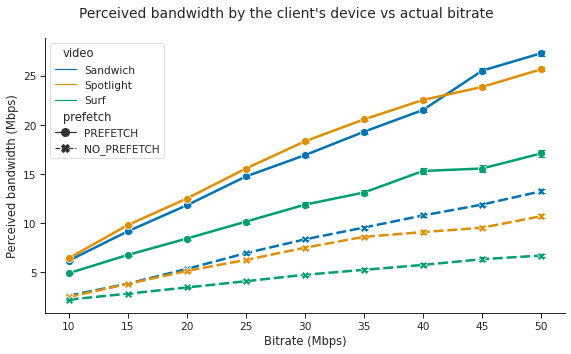

In [29]:
g = sns.relplot(x="bitrate", y="perceived_bandwidth", 
            kind="line", palette='colorblind',# col='video',
            err_style='bars', err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
            ci=68, markers=True, style='prefetch', hue='video', linewidth=2.5, 
            data=results_df, height=5, aspect=1.618, facet_kws = {'legend_out': False})

for ax in g.axes.flat:
    ax.set_xlabel("Bitrate (Mbps)")    
    ax.set_ylabel("Perceived bandwidth (Mbps)")

plt.suptitle('Perceived bandwidth by the client\'s device vs actual bitrate')
plt.tight_layout()

In [30]:
perceived_bw_df = results_df[['video', 'bitrate', 'prefetch', 'perceived_bandwidth']].groupby(['video', 'prefetch', 'bitrate']).mean().reset_index()
perceived_bw_df.head()

,video,prefetch,bitrate,perceived_bandwidth
0,Sandwich,NO_PREFETCH,10,2.619938
1,Sandwich,NO_PREFETCH,15,3.839825
2,Sandwich,NO_PREFETCH,20,5.342324
3,Sandwich,NO_PREFETCH,25,6.944886
4,Sandwich,NO_PREFETCH,30,8.350720


In [31]:
(perceived_bw_df.pivot(index=['bitrate'], columns=['prefetch', 'video'], values='perceived_bandwidth').pct_change(axis=1)['PREFETCH']*100)#.plot(kind='bar')

video,Sandwich,Spotlight,Surf
bitrate,,,
10,135.817745,157.825505,120.917992
15,138.641088,156.352154,139.290790
20,121.145620,143.152056,143.938303
25,112.275691,148.620963,148.106376
30,102.480699,144.210232,150.123663
35,102.043531,138.673375,149.799781
40,99.464442,147.891837,166.017980
45,114.523509,150.120830,145.658620
50,106.009936,139.656333,155.004418
